In [26]:
import xarray as xr
import numpy as np
import xgcm
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 16

from bbl_utils import *

import warnings
warnings.filterwarnings('ignore', '.*.')

div_cmap = plt.get_cmap('RdBu_r')
div_cmap.set_bad(color=(0.8,0.8,0.8))

cmap = plt.get_cmap('viridis')
cmap.set_bad(color=(0.8,0.8,0.8))

### Physical parameters

In [27]:
Γ = 0.0008613659531090722
θ = 2.e-3
f = 0.53e-4

### Load dataset

In [30]:
nIter = 9
step0 = 14400
nstep = step0*2

iters = range(step0,nIter*nstep+step0,nstep)
iters_mean = range(nstep, nIter*nstep, nstep)
print("Iters: ",list(iters))

Iters:  [14400, 43200, 72000, 100800, 129600, 158400, 187200, 216000, 244800]


In [31]:
data_dir = "../../MITgcm/experiments/rotated_xy-hills/run/"
ds_snap = open_mdsdataset(data_dir,iters=iters,ignore_unknown_vars=True,prefix=["snapshotDiag"])
ds = open_mdsdataset(data_dir,iters=iters_mean,ignore_unknown_vars=True,prefix=["standardDiag", "budgetDiag"])

ref_dir = "../../MITgcm/experiments/rotated/run/"
ref = open_mdsdataset(ref_dir,iters=iters_mean,ignore_unknown_vars=True,prefix=["standardDiag", "budgetDiag"])

### Pre-process dataset

In [32]:
ds, coords, grid = pre_process(ds)
ds, coords = add_cartesian_coordinates(ds, coords, θ)
ds = add_background_temp(ds, Γ)
ds, coords = add_hab_coordinates(ds, coords)

ds_snap, coords_snap, grid_snap = pre_process(ds_snap)
ds_snap, coords_snap = add_cartesian_coordinates(ds_snap, coords_snap, θ)
ds_snap = add_background_temp(ds_snap, Γ)
ds_snap, coords_snap = add_hab_coordinates(ds_snap, coords_snap)

ref, coords_ref, grid_ref = pre_process(ref)
ref, coords_ref = add_cartesian_coordinates(ref, coords_ref, θ)
ref = add_background_temp(ref, Γ)
ref, coords_ref = add_hab_coordinates(ref, coords_ref)

### Calculate derived variables

In [33]:
ζ = (-grid.diff(ds_snap.UVEL * coords_snap.dxC, 'Y', boundary='extend')
     +grid.diff(ds_snap.VVEL * coords_snap.dyC, 'X', boundary='extend'))/coords_snap.rAz

### Plotting

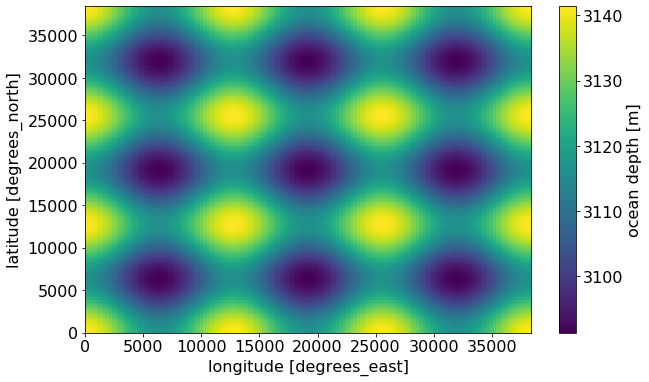

In [34]:
coords['Depth'].plot()

### Short time evolution (10 days)

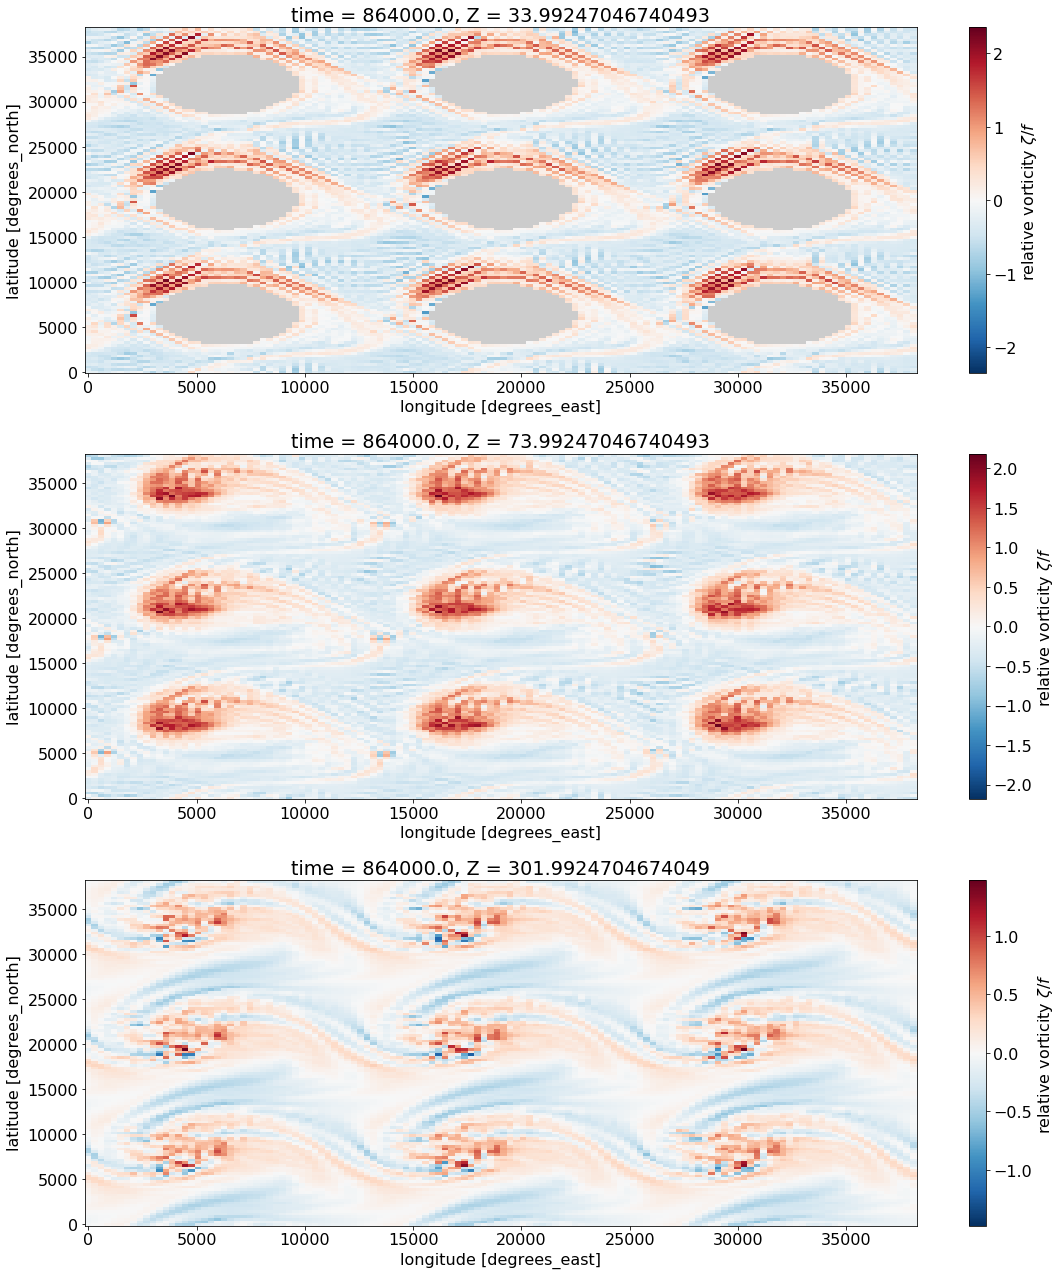

In [35]:
Z_slices = [35., 75., 300.]

fig, axes = plt.subplots(3, 1, figsize=(16,18))

ζ = ζ.where(ζ != 0.)

for i, ax in enumerate(axes):
    q = (ζ/f).sel(Z=Z_slices[i], method='nearest').isel(time=0).plot(ax=ax)
    q.colorbar.set_label(r'relative vorticity $ζ/f$')
    
plt.tight_layout()

### Long time evolution (120 days)

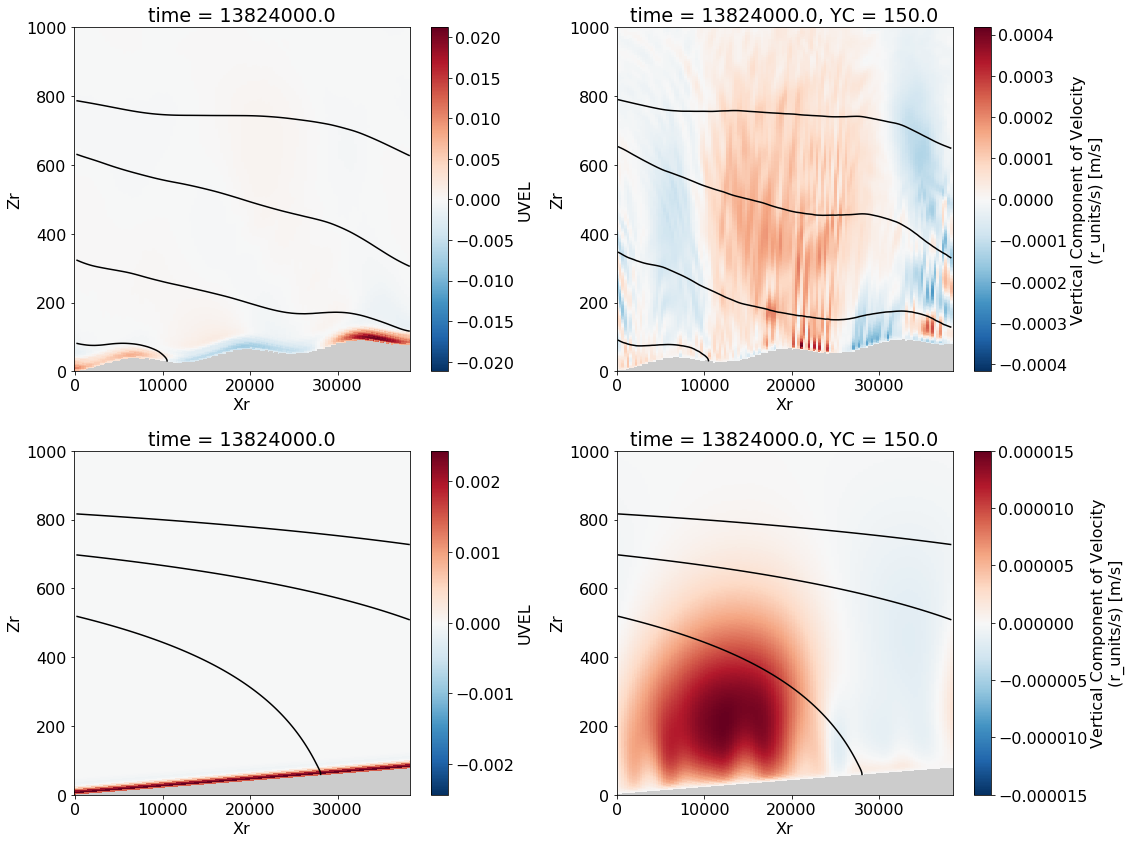

In [36]:
ds['THETA'] = ds['THETA'].where(ds['THETA'] != 0.)
ref['THETA'] = ref['THETA'].where(ref['THETA'] != 0.)

fig, axes = plt.subplots(2, 2, figsize=(16,12))

plt.subplot(2,2,1, facecolor=(.8, .8, .8))
ds['UVEL'] = ds['UVEL'].where(ds['UVEL'] != 0.)
ds['UVEL'].isel(time=-1).mean(dim=['YC'], skipna=True).plot(x='Xr_U', y='Zr_U')
ds['THETA_BG'].isel(time=-1).mean(dim=['YC'], skipna=True).plot.contour(x='Xr', y='Zr', colors='black', levels=np.arange(-0.3, 0.3, 0.05))
plt.ylim([0, 1000])

plt.subplot(2,2,2, facecolor=(.8, .8, .8))
ds['WVEL'] = ds['WVEL'].where(ds['WVEL'] != 0.)
ds['WVEL'].isel(YC=0,time=-1).plot(x='Xr_W', y='Zr_W')
ds['THETA_BG'].isel(YC=0,time=-1).plot.contour(x='Xr', y='Zr', colors='black', levels=np.arange(-0.3, 0.3, 0.05))
plt.ylim([0, 1000])

plt.subplot(2,2,3, facecolor=(.8, .8, .8))
ref['UVEL'] = ref['UVEL'].where(ref['UVEL'] != 0.)
ref['UVEL'].isel(time=-1).mean(dim=['YC'], skipna=True).plot(x='Xr_U', y='Zr_U')
ref['THETA_BG'].isel(time=-1).mean(dim=['YC'], skipna=True).plot.contour(x='Xr', y='Zr', colors='black', levels=np.arange(-0.3, 0.3, 0.05))
plt.ylim([0, 1000])

plt.subplot(2,2,4, facecolor=(.8, .8, .8))
ref['WVEL'] = ref['WVEL'].where(ref['WVEL'] != 0.)
ref['WVEL'].isel(YC=0,time=-1).plot(x='Xr_W', y='Zr_W')
ref['THETA_BG'].isel(YC=0,time=-1).plot.contour(x='Xr', y='Zr', colors='black', levels=np.arange(-0.3, 0.3, 0.05))
plt.ylim([0, 1000])

plt.tight_layout()

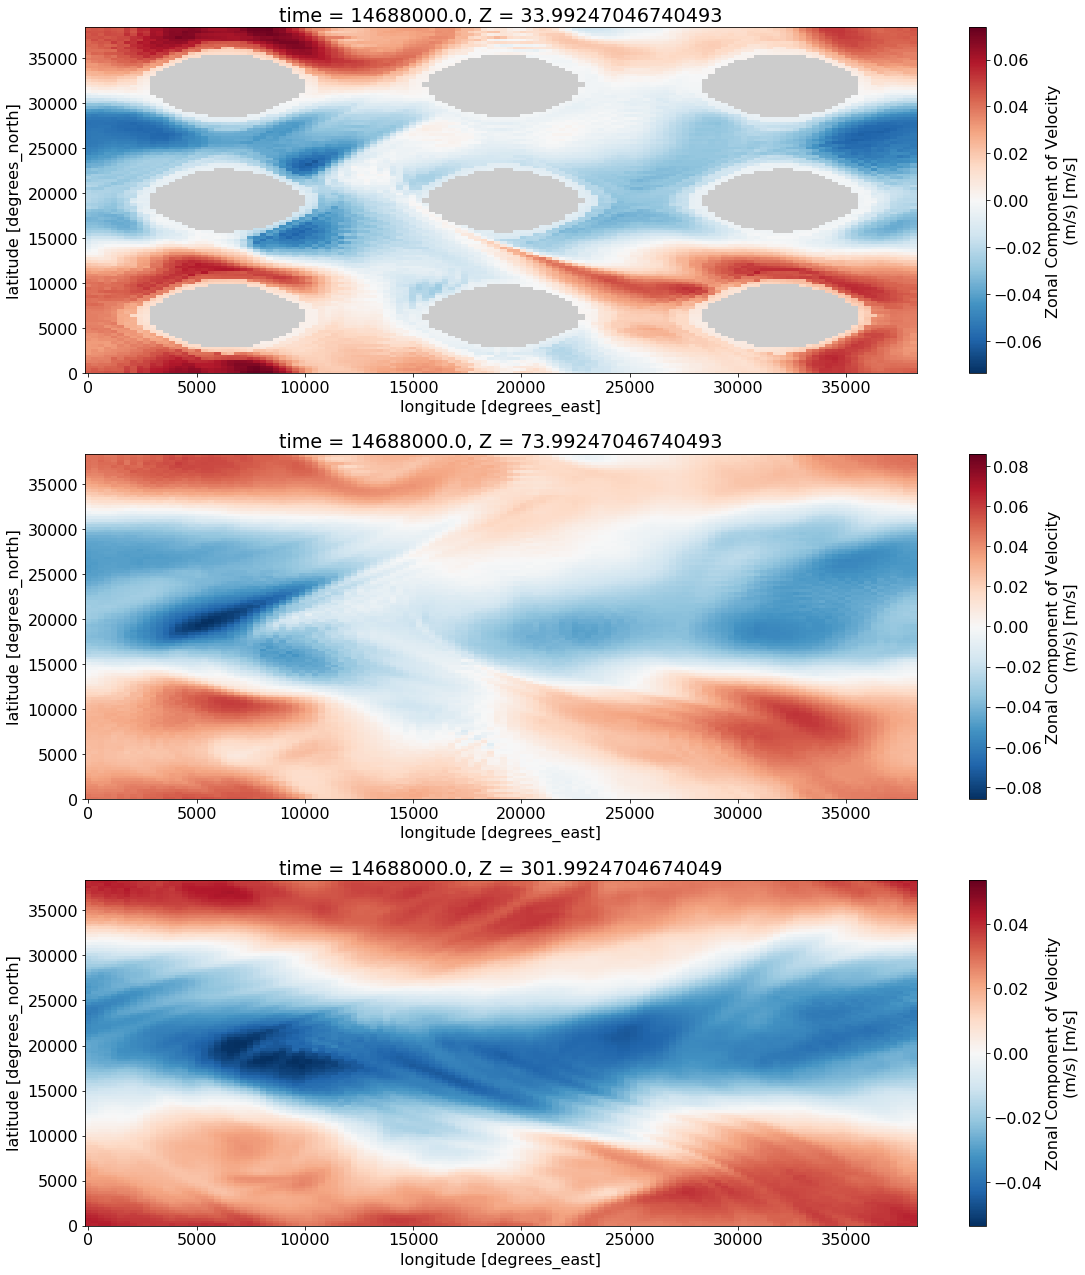

In [37]:
Z_slices = [35., 75., 300.]

fig, axes = plt.subplots(3, 1, figsize=(16,18))
ds_snap['UVEL'] = ds_snap['UVEL'].where(ds_snap['UVEL'] != 0.)

for i, ax in enumerate(axes):
    ds_snap['UVEL'].sel(Z=Z_slices[i], method='nearest').isel(time=-1).plot(ax=ax)
    
plt.tight_layout()

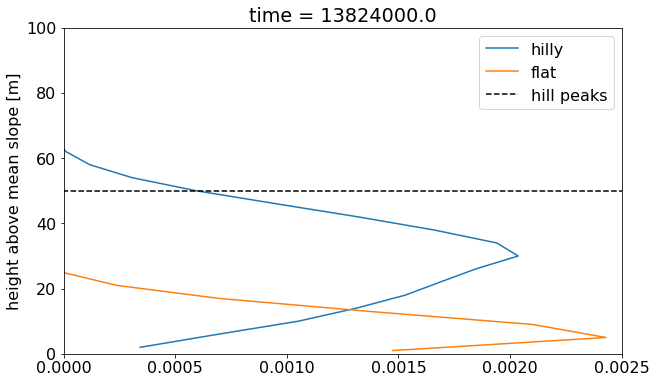

In [38]:
weighted_mean(ds['UVEL'], coords['hFacW'], dim=['XG', 'YC'], skipna=True).isel(time=-1).plot(y='Z', label='hilly')
weighted_mean(ref['UVEL'], coords_ref['hFacW'], dim=['XG', 'YC'], skipna=True).isel(time=-1).plot(y='Z', label='flat')
plt.ylim([0,100])
plt.xlim([0,2.5e-3])
plt.plot([-1,1], np.array([1,1]) * (coords['Depth'].max() - coords['Depth'].min()).values, "k--", label='hill peaks')
plt.legend()
plt.ylabel('height above mean slope [m]');